In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')
import important_functionalities as impf

2025-03-14 02:07:02.426892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2.6. Running a model experiment using 100% of augmented training data with fine tuning**

| Experiment | Data       | Preprocessing | Model          |
|------------|------------|---------------|----------------|
| Model 4     | 10 classes of food101 dataset (100% training data)  | Same as Model 1       | Same as Model 3|

* We have loaded a feature extraction model (Model 2) trained on 10% data (with augmentation) for 5 epochs (using model checkpoint weights)
* Now we will unfreeze last 10 layers and train the model on complete (all) data

In [2]:
# load data
data_dir='/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/5_convolutional_neural_network/10_food_classes_all_data'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/test'

In [ ]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=IMAGE_SHAPE,
                                                               label_mode='categorical',
                                                                batch_size=BATCH_SIZE
                                                               )
valid_data=tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                               image_size=IMAGE_SHAPE,
                                                                label_mode='categorical',
                                                                 batch_size=BATCH_SIZE
                                                                )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
# Creating Model 3

### 1. Create data augmentation stage with horizontal flipping, rotations, zooms etc

### We can create a layer for our functional API models using Sequential API
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.experimental.preprocessing.Rescaling(1./255)# keep for models like ResNet50V2 but EfficientNet has rescaling built-in,
],name='data_augmentation')

In [5]:
input_shape=(224,224,3)
### 2. Create the base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,#exclude o/p layer
                                                                  weights='imagenet',
                                                                 input_shape=input_shape) 

### 3. Freeze the layers in the base model
base_model.trainable=False # keeps  model in inference mode, this also ensures batchnorm statistics don't get updated

### 4. Create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')    
print(f"Shape of inputs: {inputs.shape}")
### 5. Adding data augmentation sequential layer model as a layer
x=data_augmentation(inputs,training=True)
print(f"Shape after data_augmentation: {x.shape}") 

### 6. Pass the inputs to the base_model
x = base_model(x)
print(f"Shape after base_model: {x.shape}")

### 7. max pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_max_pooling_layer')(x)
print(f"After GlobalmaxPooling2D(): {x.shape}")

### 8. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

### 9. Combine the inputs with the outputs into a model
model_4=tf.keras.Model(inputs,outputs,name='model_4')


### 10. Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### 11. Viewing model summary
model_4.summary()

Shape of inputs: (None, 224, 224, 3)
Shape after data_augmentation: (None, None, None, 3)
Shape after base_model: (None, None, None, 1280)
After GlobalmaxPooling2D(): (None, 1280)


Model: "model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [6]:
### 12. Creating a model checkpoint callback
##### set checkpoint path
checkpoint_path = "model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5"

#### create model checkpoint which saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

In [7]:
# load in saved model weights and evaluate model
model_4.load_weights(checkpoint_path)

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
# evaluate model 2 with loaded weights
loaded_weights_model_results = model_4.evaluate(valid_data)  

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 620ms/step - accuracy: 0.8165 - loss: 0.6842


In [9]:
loaded_weights_model_results

[0.689574658870697, 0.8151999711990356]

In [10]:
# checking layers in our base model and see if they're trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [11]:
# fine-tuning, lets start by unfreezing the top 10 layers of our base model
base_model.trainable=True

# freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False 

# recompile the model (model needs to be recompiled after any changes)
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=['accuracy'])

In [12]:
# check which layers are tunable (trainable)
for layer_number,layer in enumerate(model_4.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [13]:
# checking the trainable parameters 
print(model_4.trainable_variables.__len__())

12


In [14]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5 # model has already done 5 epochs (we're going to fine-tune for 6 more)

# refit the model (same as model_3, but fitted to all data)
history_all_model_4_fine_tuned=model_4.fit(train_data,
                                        epochs=fine_tune_epochs,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        initial_epoch=initial_epochs, # start from previous last epoch
                                        callbacks=[impf.create_tensorboard_callback(dir_name="transfer_learning",experiment_name="all_feature_extraction_fine_tune_last_10")])

Saving TensorBoard log files to : transfer_learning/all_feature_extraction_fine_tune_last_10/20250314-021544
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 221s 903ms/step - accuracy: 0.7175 - loss: 1.0253 - val_accuracy: 0.8750 - val_loss: 0.4216
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 205s 871ms/step - accuracy: 0.7773 - loss: 0.7393 - val_accuracy: 0.8865 - val_loss: 0.3477
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 202s 861ms/step - accuracy: 0.8007 - loss: 0.6554 - val_accuracy: 0.8997 - val_loss: 0.3226
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 197s 837ms/step - accuracy: 0.8158 - loss: 0.6079 - val_accuracy: 0.9062 - val_loss: 0.2805
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 200s 852ms/step - accuracy: 0.8304 - loss: 0.5554 - val_accuracy: 0.9095 - val_loss: 0.2654


In [15]:
loaded_weights_model_results

[0.689574658870697, 0.8151999711990356]

In [16]:
# evaluate the fine tuned model
results_fine_tuned_all_data_aug = model_4.evaluate(valid_data)
results_fine_tuned_all_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 644ms/step - accuracy: 0.9085 - loss: 0.2735


[0.27680647373199463, 0.909600019454956]

<Figure size 640x480 with 0 Axes>

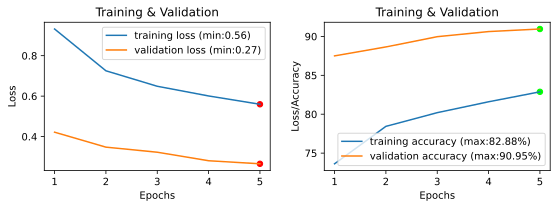

In [17]:
# plot the loss curves of fine-tuned model
impf.plot_loss_curves(history_all_model_4_fine_tuned)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


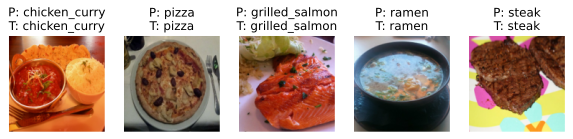

In [67]:
# Select the first batch of validation data
valid_data_batch = next(iter(valid_data))

# Select 5 images from the first batch
images_batch, labels_batch = valid_data_batch
selected_images = images_batch[:5]

# Make predictions using model_4
predictions = model_4.predict(selected_images)

# Convert predictions to class names
predicted_class_names = [valid_data.class_names[tf.argmax(prediction)] for prediction in predictions]

# Display the selected images and their predicted class names
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(selected_images[i].numpy().astype("uint8"))
    plt.title(f"P: {predicted_class_names[i]}\nT: {valid_data.class_names[tf.argmax(labels_batch[i])]}")
    plt.axis("off")
plt.show()

In [71]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

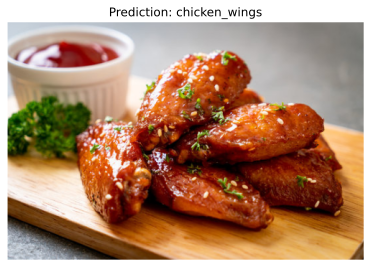

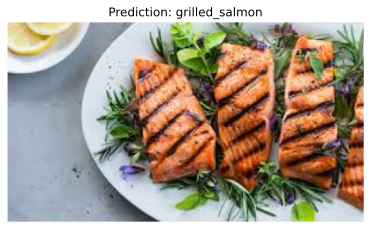

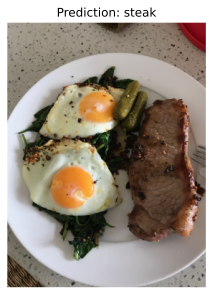

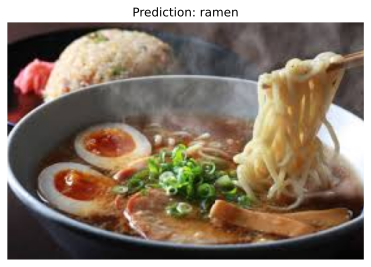

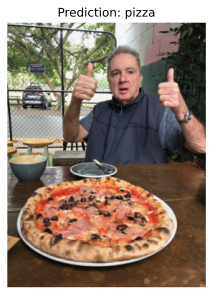

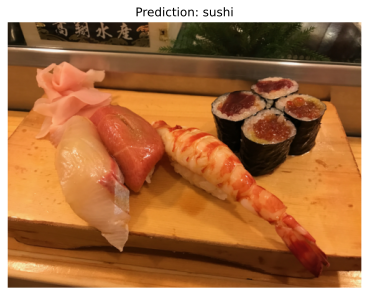

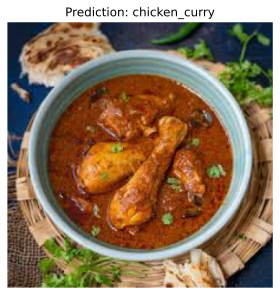

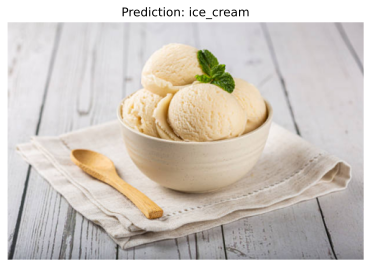

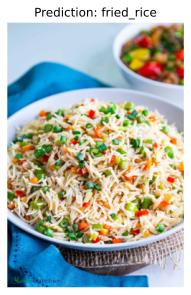

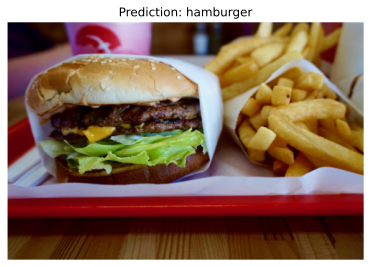

In [72]:
def load_preprocess(filename,shape=(224,224,3)):
    # load the image
    img=tf.io.read_file(filename=filename)
    img=tf.image.decode_image(img)
    
    # resize
    img=tf.image.resize(img,shape[:2])

    # expand-dims
    img=tf.expand_dims(img,axis=0)

    # # rescale/normalize image (DON'T DO THIS)
    # img=img/255.0
    return img

def pred_plot(model,filename,class_names):
    img=load_preprocess(filename)
    prediction=class_names[tf.argmax(tf.squeeze(model.predict(img,verbose=0)))]  
    plt.imshow(tf.squeeze(plt.imread(filename)))
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show() 

import os 
for file in os.listdir(f'{data_dir}/custom_images'):
    pred_plot(model_4,f'{data_dir}/custom_images/{file}',train_data.class_names)

**Conclusion:**

| Experiment | Data       | Preprocessing | Model          |Max-Train Acc|Max-Val Acc|
|------------|------------|---------------|----------------|----------------|----------------|
| Model 0<br>(baseline)     | 10 classes of food101 dataset (random 10% training data only)  | None        | Feature Extractor: EfficientNetB0 (pretrained on ImageNet, all layers frozen) with no top|83.72%|86.53%|
| Model 1     | 10 classes of food101 dataset (random 1% training data only)  | Random flip, Rotation, Height, Width data-augmentation       | Same as Model 0|62.86%|43.09%|
| Model 2     | Same as Model 0  | Same as Model 1       | Same as Model 0|79.07|80.76|
| Model 3     | Same as Model 0  | Same as Model 1       | Fine-tuning: Model2(EfficientNetB0 pretrained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen|82.93|84.05|
| Model 4     | 10 classes of food101 dataset (100% training data)  | Same as Model 1       | Same as Model 3|82.88|90.95|

**Observations**
* Only feature extraction model performs good on 10% training data (without augmentation)
* Feature extraction model performs deteriorates on 1% even after augmentation
* Feature extraction model losses accuracy on 10% training data after augmentation
* Fine tuning the feature extraction model increases accuracy on 10% training data after augmentation
* Fine tuning the feature extraction model (pretrained on 10% data after augmentation) increases accuracy drastically after fine tuning on 100% data after augmentation